<a href="https://colab.research.google.com/github/Tommyodetunde/Game/blob/main/CP322_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CP322 Final Project

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving car.data to car.data
User uploaded file "car.data" with length 51916 bytes


Report: https://docs.google.com/document/d/1voiHl5IFIeswMA8kFqHJroYCtfZKcXnbXOSF94Ume6c/edit

Dataset: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

In [ ]:
#Import libraries
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import nltk
import re
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import urllib
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score
from time import time

In [ ]:
car_data = pd.read_csv("car.data")
car_data.columns = ['buying' , 'maint', 'doors' , 'persons','lug_boot','safety','class']

car_data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


**Data Preprocessing**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   buying    1728 non-null   int64
 1   maint     1728 non-null   int64
 2   doors     1728 non-null   int64
 3   persons   1728 non-null   int64
 4   lug_boot  1728 non-null   int64
 5   safety    1728 non-null   int64
 6   class     1728 non-null   int64
dtypes: int64(7)
memory usage: 94.6 KB

Median:
 buying      2.5
maint       2.5
doors       3.5
persons     4.0
lug_boot    2.0
safety      2.0
class       1.0
dtype: float64

Mode:
    buying  maint  doors  persons  lug_boot  safety  class
0       1      1      2      2.0       1.0     1.0    1.0
1       2      2      3      4.0       2.0     2.0    NaN
2       3      3      4      5.0       3.0     3.0    NaN
3       4      4      5      NaN       NaN     NaN    NaN

Mean:
 buying      2.500000
maint       2.500000
doors       3.500000
persons     3.66

(1728, 7)

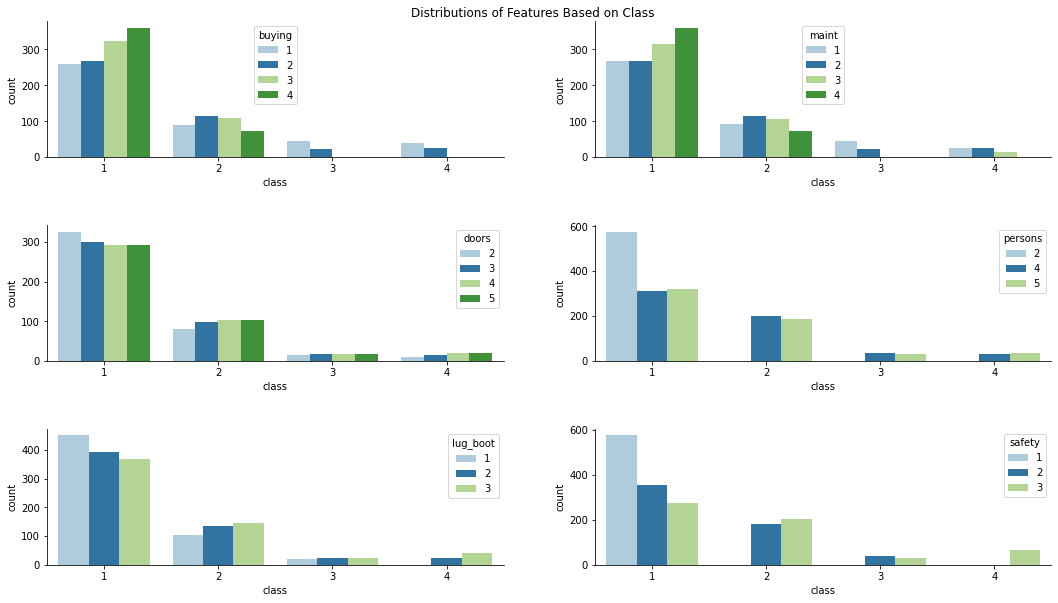

In [ ]:
figure, plotfeature = plt.subplots(3, 2, figsize = (18, 10))
plt.subplots_adjust(hspace = 0.5)

figure.suptitle('Distributions of Features Based on Class', y = 0.9, fontsize = 12)

for attribute, col in enumerate(car_data.columns[:-1]):
  sns.countplot(data = car_data, x = 'class', hue = col, ax = plotfeature.flat[attribute], palette = 'Paired');

sns.despine()
car_data = car_data.replace({'doors':{'2':2,'3':3,'4':4,'5more':5}})
car_data = car_data.replace({'persons':{'2':2,'4':4,'more':5}})
car_data = car_data.replace({'class':{'unacc':1,'acc':2,'good':3,'vgood':4}})
car_data = car_data.replace({'buying':{'low':1,'med':2,'high':3,'vhigh':4}})
car_data = car_data.replace({'maint':{'low':1,'med':2,'high':3,'vhigh':4}})
car_data = car_data.replace({'safety':{'low':1,'med':2,'high':3}})
car_data = car_data.replace({'lug_boot':{'small':1,'med':2,'big':3}})
car_data.info()
car_data.shape

**Visualization of Preprocessing**

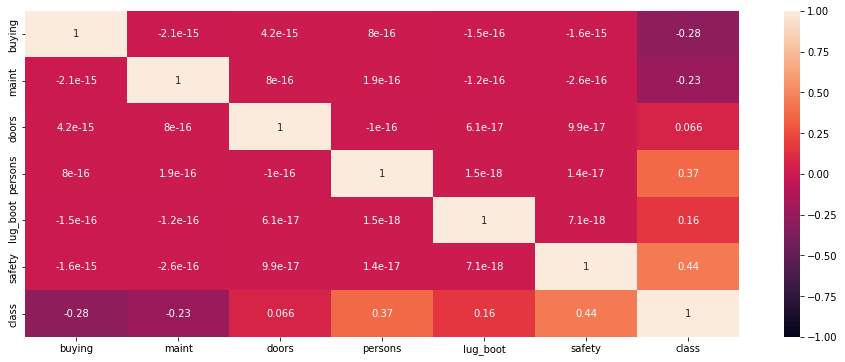

In [ ]:
# sns.pairplot(car_data)
# car_data.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(car_data.corr(), vmin=-1, vmax=1, annot=True)
# sns.heatmap(car_data.corr())
# car_data.hist(bins=5,figsize=(20,15))


**Data Quality Report**

In [ ]:
data_types = pd.DataFrame(
    car_data.dtypes,
    columns=['Data Type']
)

unique_values = pd.DataFrame(
    columns=['Unique Values'])

for row in list(car_data.columns.values):
    unique_values.loc[row] = [car_data[row].nunique()]

quality_report = data_types.join(unique_values)
print(quality_report)

print("\nMedian:")
print(car_data.median())
print("\nMode:\n")
print(car_data.mode())
print("\nMean:\n")
print(car_data.mean())
#Each one of the unique values is attributes for our features

         Data Type Unique Values
buying       int64             4
maint        int64             4
doors        int64             4
persons      int64             3
lug_boot     int64             3
safety       int64             3
class        int64             4

Median:
buying      2.5
maint       2.5
doors       3.5
persons     4.0
lug_boot    2.0
safety      2.0
class       1.0
dtype: float64

Mode:

   buying  maint  doors  persons  lug_boot  safety  class
0       1      1      2      2.0       1.0     1.0    1.0
1       2      2      3      4.0       2.0     2.0    NaN
2       3      3      4      5.0       3.0     3.0    NaN
3       4      4      5      NaN       NaN     NaN    NaN

Mean:

buying      2.500000
maint       2.500000
doors       3.500000
persons     3.666667
lug_boot    2.000000
safety      2.000000
class       1.414931
dtype: float64


**Model Selection - LogisticRegression**

In [ ]:
features = car_data.loc[:, 'buying':'safety']
target = car_data['class']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000, solver='lbfgs')

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

**Model Selection - KNN**

In [ ]:
featuresForSecondModel = car_data.loc[:, 'buying':'safety']
targetForSecondModel = car_data['class']


X2_train, X2_test, y2_train, y2_test = train_test_split(features, target, test_size=0.2, random_state=42)
knnModel = KNeighborsClassifier(n_neighbors = 5)

knnModel.fit(X2_train, y2_train)

KNeighborsClassifier()

**Model Evaluation, Performance and Results**

In [ ]:
def predictLogistical():
  start = time()
  y_pred = model.predict(X_test)
  end = time()
  print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3))
  print("Precision: ", round(precision_score(y_test, y_pred, average='weighted'), 3))
  print("Recall: ", round(recall_score(y_test, y_pred, average='weighted'), 3))
  print("Latency: ", round((end-start) * 1000, 3), "ms\n")

def predictKNN():
  start = time()
  y2_pred = knnModel.predict(X_test)
  end = time()
  print("Accuracy: ", round(accuracy_score(y2_test, y2_pred), 3))
  print("Precision: ", round(precision_score(y2_test, y2_pred, average='weighted'), 3))
  print("Recall: ", round(recall_score(y2_test, y2_pred, average='weighted'), 3))
  print("Latency: ", round((end-start) * 1000, 3), "ms")

print("Logistical: " )
predictLogistical()
print("K-nearest neighbors: ")
predictKNN()



Logistical: 
Accuracy:  0.835
Precision:  0.827
Recall:  0.835
Latency:  2.223 ms

K-nearest neighbors: 
Accuracy:  0.951
Precision:  0.952
Recall:  0.951
Latency:  16.499 ms
